In [1]:
import numpy as np
from ptychoSampling.utils.imgUtils import getTestImage
import skimage
from skimage.feature import register_translation
from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
recons_obj = np.load('vanilla_adam_recons_obj.npy')
recons_probe = np.load('vanilla_adam_recons_probe.npy')
probe_true = np.load('probe_true.npy')

In [6]:
scaling_factor = 4
# Model parameters.
params = {'z':0.0468, #Effective Propagation distance from sample to detector(m)
          'npix_x':2048 // scaling_factor, # number of object pixels in x-direction
          'npix_y':2048 // scaling_factor, # number of y object pixels
          'dx':75e-9 * scaling_factor, # Effective detector pixel size (m)
          'dy':75e-9 * scaling_factor,
          #'Energy':14.96, # energy of incident beam (keV)
          'Energy':8.7, #energy of incident beam (keV)
          'flux':10000, # photons/pixel
          'step_size':20e-6, # step size (m)
          #'wavelength':7.31e-11 # wavelength (m)
          'wavelength': 0.142e-9 #wavelength (m)
        }
probe_npix = params['npix_x']
obj_variable_npix = probe_npix //2
step_size_pix = int(np.ceil(params['step_size'] // params['dx'])) # pixels 
num_steps = 5; step_size_pix = (step_size_pix //2) * 4 // 3

In [7]:
obj_variable_npix = recons_obj.shape[0]
img_obj = getTestImage()
buffer_npix = 32
amp = skimage.transform.resize(np.abs(img_obj), 
                               [obj_variable_npix,# - buffer_npix * 2, 
                                obj_variable_npix],# - buffer_npix * 2], 
                               mode='wrap', 
                               preserve_range=True)
phase = skimage.transform.resize(np.angle(img_obj), 
                                 [obj_variable_npix,# - buffer_npix * 2, 
                                  obj_variable_npix],# - buffer_npix * 2], 
                                 mode='wrap', 
                                 preserve_range=True)
obj_true = amp * np.exp(1j * phase)

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [8]:
scaling_factor = np.sqrt((np.abs(probe_true)**2).sum() / (np.abs(recons_probe)**2).sum())
scaling_factor

0.9999496620042508

In [9]:
rollo, erro, phaseo = register_translation(obj_true, recons_obj)
recons_obj_new = np.roll(recons_obj, rollo.astype('int'), axis=(0,1)) * np.exp(1j * phaseo) #/ scaling_factor
register_translation(obj_true, recons_obj_new)

(array([0., 0.]), 0.008389243529507862, -1.6614969510081147e-08)

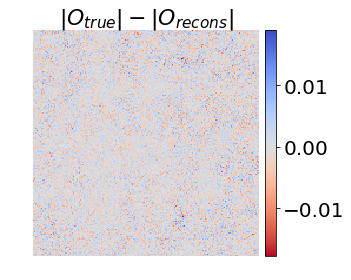

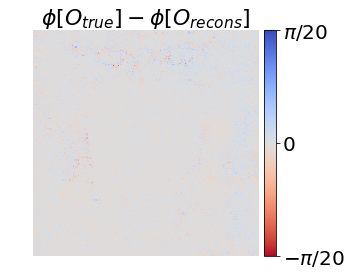

In [10]:
# Plot the differences in the reconstructed vs true object and probe
x1 = obj_true
x2 = recons_obj_new

Z1 = np.abs(x1) - np.abs(x2)
#Z1 = np.abs(x1 - x2)
Z2 = np.angle(np.exp(1j * (np.angle(x1) - np.angle(x2))))

#Z2[x1 == 0] = 0


#abs_title = r'$\left(\lVert O_{true}\rVert -\lVert O_{recons}\rVert\right)$'
abs_title = r'$\|O_{true}\| - \|O_{recons}\|$'
phase_title = r'$\phi[O_{true}]-\phi[O_{recons}]$'

norm = MidpointNormalize(midpoint=0)

save_plots = True

if save_plots:
    fig = plt.figure(figsize=[5,4])
else:
    fig = plt.figure(figsize=[5,4])
ax = plt.subplot(1,1,1)
#cax = plt.pcolormesh(Z1, cmap='coolwarm', norm=norm, rasterized=True )#, vmin=min(Z1.min(), -0.1), vmax=max(Z1.max(),0.1), cmap='seismic', rasterized=True)
cax = plt.imshow(Z1[::-1], cmap='coolwarm_r', norm=norm, vmin=Z1.min(), vmax=Z1.max())
cax.axes.set_axis_off()
plt.title(abs_title, fontsize=22)
cb = plt.colorbar(ticks=[-0.01, 0, 0.01], pad=0.02)
cb.ax.tick_params(labelsize=20)

ax.set_aspect('equal')
plt.tight_layout()
if save_plots:
    plt.savefig('differences_obj_abs_true_adam.pdf', bbox_inches='tight')
plt.show()


Z2[np.abs(x2)<.0001] = 0

#cmap = plt.cm.YlOrRd
cmap = plt.cm.coolwarm_r
normalized_angles = MidpointNormalize(vmin=-np.pi/20, midpoint=0, vmax=np.pi/20)(Z2[::-1])
colors = cmap(normalized_angles)

alphas = Normalize(vmin=0,vmax=np.abs(Z1).max(),clip=True)(np.abs(Z1[::-1]))
colors[...,-1] = 1#alphas

greys = np.empty(alphas.shape + (3,), dtype=np.uint8)
greys.fill(0)


if save_plots:
    fig = plt.figure(figsize=[5,4])
else:
    fig = plt.figure(figsize=[5,4])

ax = plt.subplot(1,1,1)

plt.imshow(greys, aspect='equal')
plt.imshow(colors, aspect='equal', vmin=-np.pi/20, vmax=np.pi/20, cmap=cmap, interpolation=None)
ax.set_axis_off()
cb = plt.colorbar(pad=0.02, ticks=[-np.pi/20, 0, np.pi/20])#, orientation='vertical',aspect=30)

plt.title(phase_title, fontsize=22)
cb.ax.tick_params(labelsize=20) 
cb.ax.set_yticklabels([r'$-\pi/20$', r'0', r'$\pi/20$'])
ax.set_aspect('equal')
plt.tight_layout()
if save_plots:
    plt.savefig('differences_obj_phase_true_adam.pdf', bbox_inches='tight')
plt.show()

In [11]:
rollp, errp, phasep = register_translation(probe_true, recons_probe)
recons_probe_new = np.roll(recons_probe, rollp.astype('int'), axis=(0,1)) * np.exp(1j * phasep) # scaling_factor
register_translation(probe_true, recons_probe_new)

(array([0., 0.]), 0.10709696089002178, -1.2076951366191792e-09)

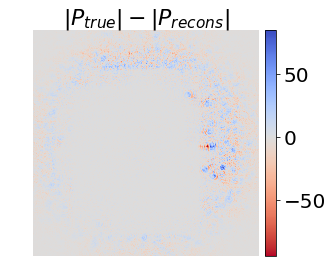

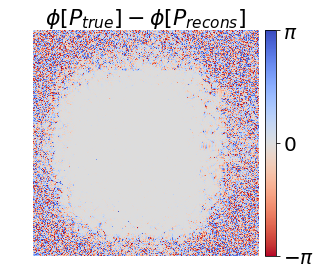

In [12]:
# Plot the differences in the reconstructed vs true object and probe
x1 = probe_true
x2 = recons_probe_new

Z1 = np.abs(x1) - np.abs(x2)
#Z1 = np.abs(x1 - x2)
Z2 = np.angle(np.exp(1j * (np.angle(x1) - np.angle(x2))))

#Z2[x1 == 0] = 0


#abs_title = r'$\left(\lVert O_{true}\rVert -\lVert O_{recons}\rVert\right)$'
abs_title = r'$\|P_{true}\| - \|P_{recons}\|$'
phase_title = r'$\phi[P_{true}]-\phi[P_{recons}]$'

norm = MidpointNormalize(midpoint=0)

save_plots = True

if save_plots:
    fig = plt.figure(figsize=[5,4])
else:
    fig = plt.figure(figsize=[5,4])
ax = plt.subplot(1,1,1)
#cax = plt.pcolormesh(Z1, cmap='coolwarm', norm=norm, rasterized=True )#, vmin=min(Z1.min(), -0.1), vmax=max(Z1.max(),0.1), cmap='seismic', rasterized=True)
cax = plt.imshow(Z1[::-1], cmap='coolwarm_r', norm=norm, vmin=Z1.min(), vmax=Z1.max())
cax.axes.set_axis_off()
plt.title(abs_title, fontsize=22)
cb = plt.colorbar(ticks=[-50, 0, 50], pad=0.02)
cb.ax.tick_params(labelsize=20)

ax.set_aspect('equal')
plt.tight_layout()
if save_plots:
    plt.savefig('differences_probe_abs_true_adam.pdf', bbox_inches='tight')
plt.show()


Z2[np.abs(x2)<.01] = 0

#cmap = plt.cm.YlOrRd
cmap = plt.cm.coolwarm_r
normalized_angles = MidpointNormalize(vmin=-np.pi, midpoint=0, vmax=np.pi)(Z2[::-1])
colors = cmap(normalized_angles)

alphas = Normalize(vmin=0,vmax=np.abs(Z1).max(),clip=True)(np.abs(Z1[::-1]))
colors[...,-1] = 1#alphas

greys = np.empty(alphas.shape + (3,), dtype=np.uint8)
greys.fill(0)


if save_plots:
    fig = plt.figure(figsize=[5,4])
else:
    fig = plt.figure(figsize=[5,4])

ax = plt.subplot(1,1,1)

plt.imshow(greys, aspect='equal')
plt.imshow(colors, aspect='equal', vmin=-np.pi, vmax=np.pi, cmap=cmap, interpolation=None)
ax.set_axis_off()
cb = plt.colorbar(pad=0.02, ticks=[-np.pi, 0, np.pi])#, orientation='vertical',aspect=30)

plt.title(phase_title, fontsize=22)
cb.ax.tick_params(labelsize=20) 
cb.ax.set_yticklabels([r'$-\pi$', r'0', r'$\pi$'])
ax.set_aspect('equal')
plt.tight_layout()
if save_plots:
    plt.savefig('differences_probe_phase_true_adam.pdf', bbox_inches='tight')
plt.show()

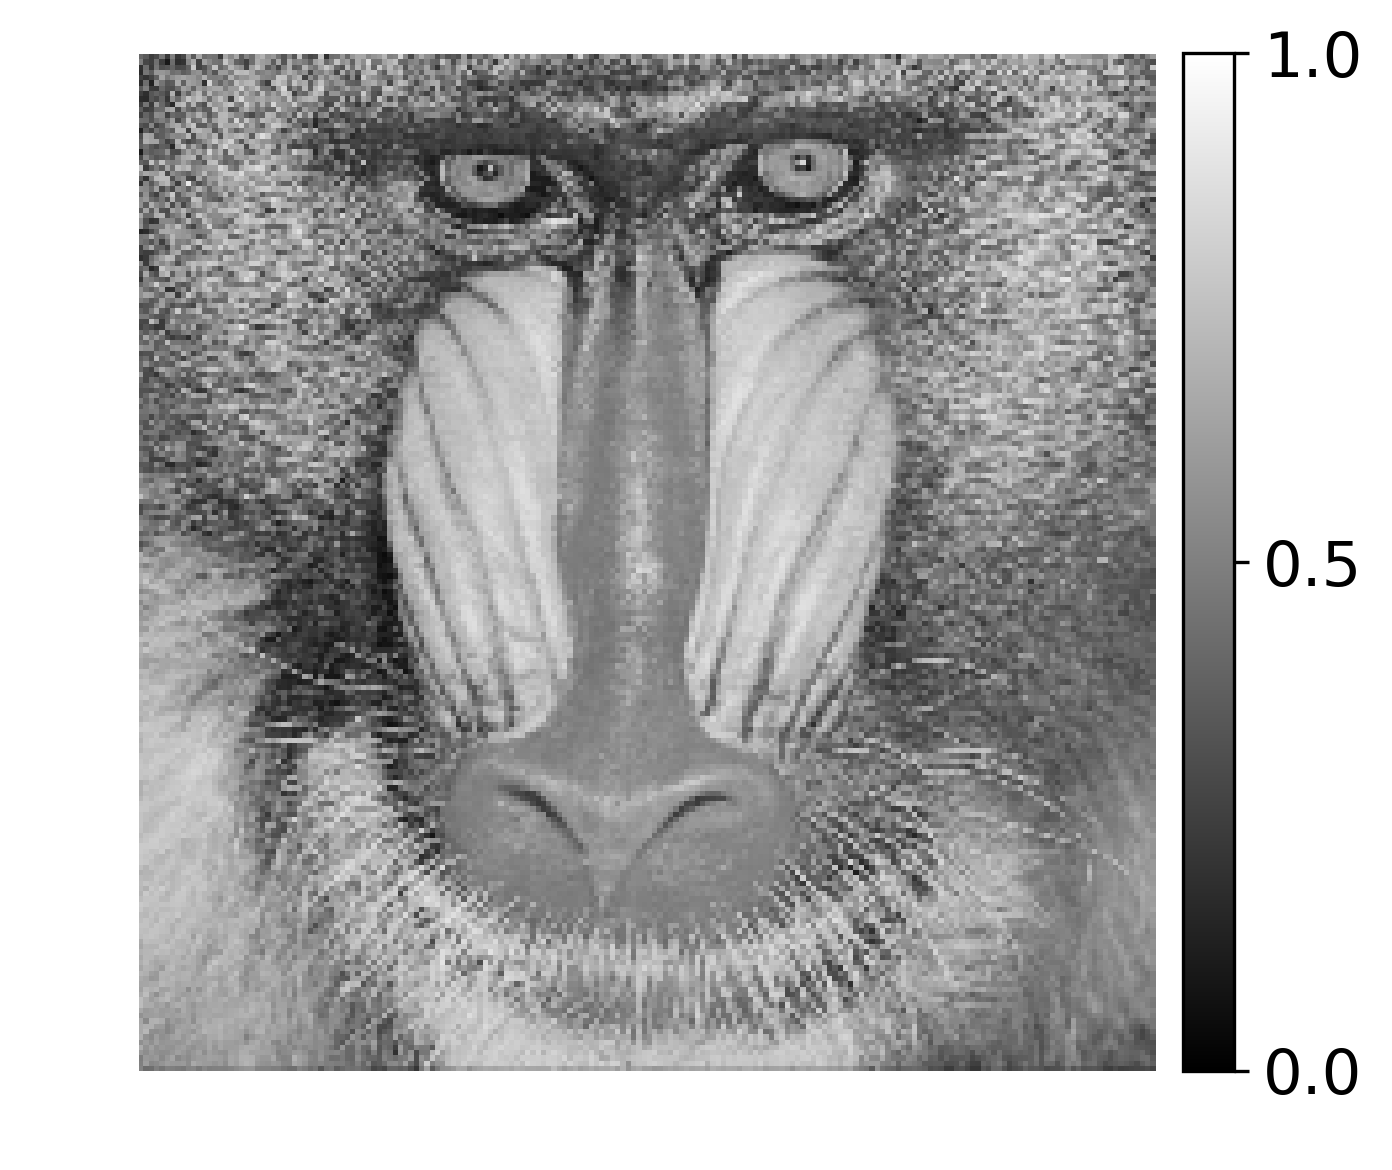

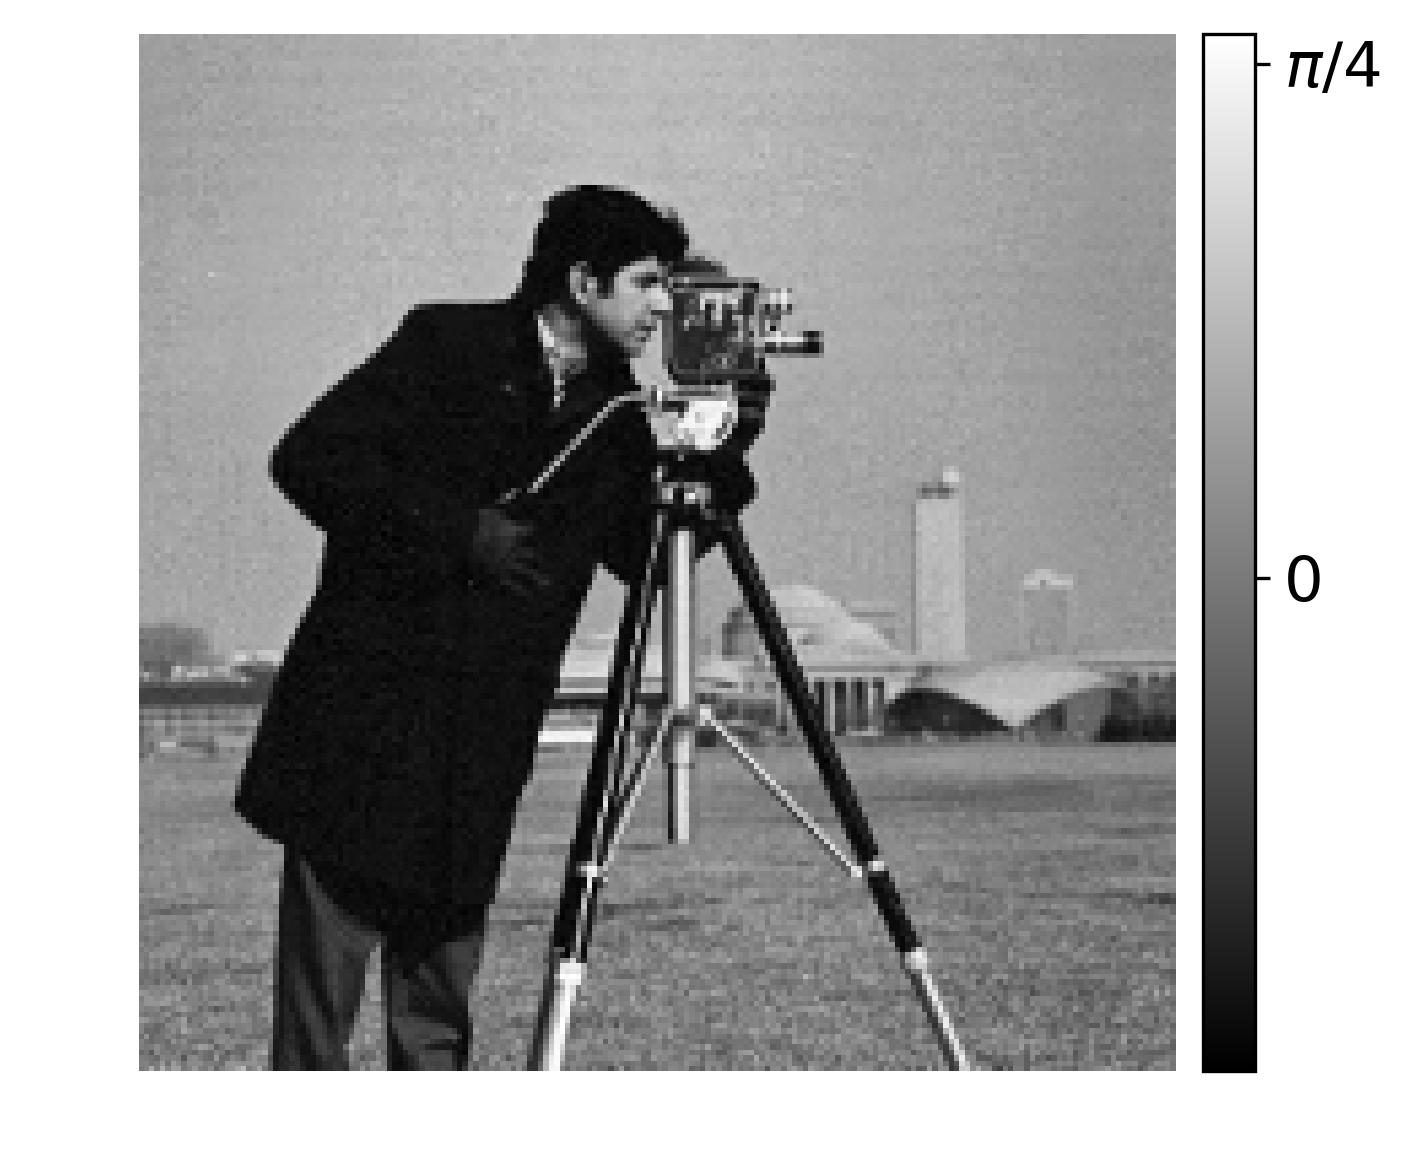

In [13]:
plt.figure(figsize=[5,4], dpi=300)
ax = plt.subplot(1,1,1)
cax = plt.pcolormesh(np.abs(recons_obj), cmap='gray', vmin=0, vmax=1, rasterized=True)
cax.axes.set_axis_off()
cb = plt.colorbar(cax, ticks=[0, 0.5, 1], pad=0.02)
cb.ax.tick_params(labelsize=15)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('recons_obj_abs.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=[5,4], dpi=300)
ax = plt.subplot(1,1,1)
cax = plt.pcolormesh(np.angle(recons_obj), cmap='gray', rasterized=True)
cb = plt.colorbar(cax, ticks=[-np.pi/4, 0, np.pi/4], pad=0.02)
cb.ax.set_yticklabels([r'$-\pi/4$', '0', r'$\pi/4$'])
cb.ax.tick_params(labelsize=15)
cax.axes.set_axis_off()
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('recons_obj_phase.pdf', bbox_inches='tight')
plt.show()

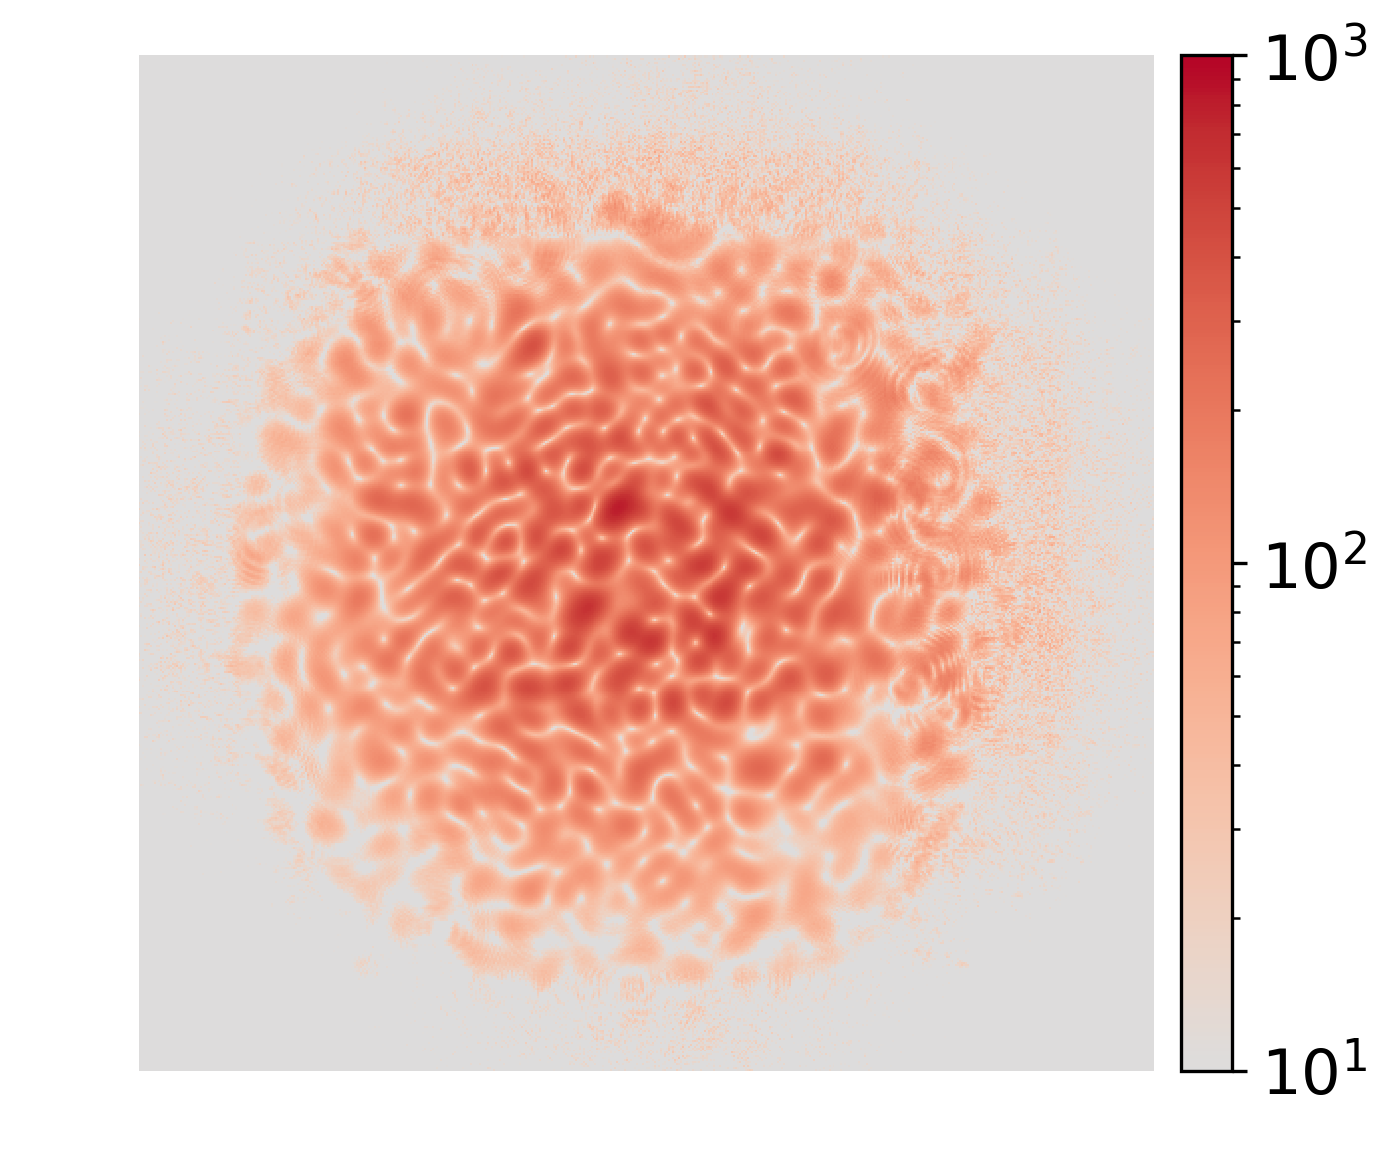

In [14]:
absvals = np.abs(recons_probe)
angvals = np.angle(recons_probe)

absvals[absvals<10] = 10

new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1)
plt.figure(figsize=[5,4], dpi=300)
ax = plt.subplot(1,1,1)
ax.set_axis_off()

cax = plt.pcolormesh(absvals, cmap=new_cmap,
                     norm=LogNorm(vmin=10, vmax=1000),
                     rasterized=True)
cax.axes.set_axis_off()
cb = plt.colorbar(cax, ticks=[10, 100, 1000], pad=0.02)
cb.ax.tick_params(labelsize=15)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('recons_probe_abs.pdf', bbox_inches='tight')
plt.show()


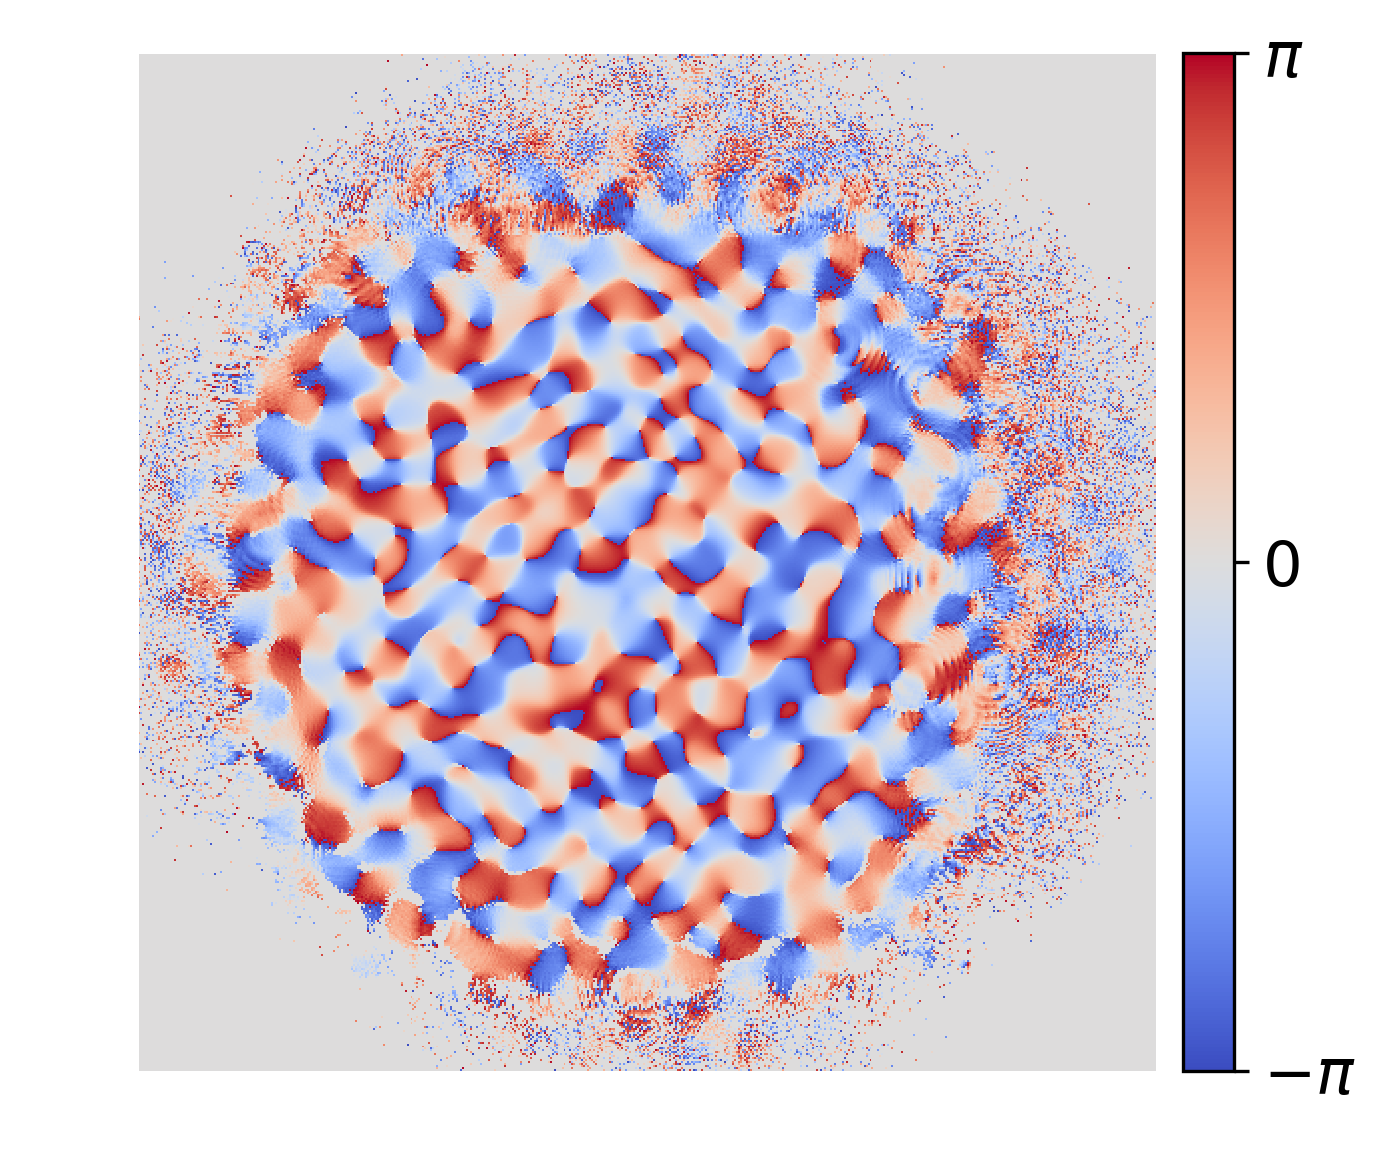

In [15]:
angvals[absvals <= 10] = 0
plt.figure(figsize=[5,4], dpi=300)
ax = plt.subplot(1,1,1)
ax.set_axis_off()

cax = plt.pcolormesh(angvals, cmap='coolwarm',
                     norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0),
                     rasterized=True)
cax.axes.set_axis_off()
cb = plt.colorbar(cax, ticks=[-np.pi, 0, np.pi], pad=0.02)
cb.ax.set_yticklabels([r'$-\pi$', r'0', r'$\pi$'])
cb.ax.tick_params(labelsize=15)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('recons_probe_phase.pdf', bbox_inches='tight')
plt.show()